# Projet IA

## Imports des bibliothèques

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

!pip install scikit-learn==1.7.0
import sklearn
#print(f"Scikit-learn version in current environment: {sklearn.__version__}")

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier




## 1. Chargez les données et les stocker dans une variable df.

In [11]:
df = pd.read_csv('creditcarddata.csv')
print("Dimensions :", df.shape)
df.head()


Dimensions : (2266, 14)


,Gender,Age,HouseTypeID,ContactAvaliabilityID,HomeCountry,AccountNo,CardExpiryDate,TransactionAmount,TransactionCountry,LargePurchase,ProductID,CIF,TransactionCurrencyCode,PotentialFraud
0,0,56,1,0,1,1109976,1811,0.0062,1,0,3,11020290,1,0
1,0,56,1,0,1,1109976,1811,0.0062,1,0,3,11020290,1,0
2,0,56,1,0,1,1109976,1811,0.0062,1,0,3,11020290,1,0
3,0,56,1,0,1,1109976,1811,0.0062,1,0,3,11020290,1,0
4,0,56,1,0,1,1109976,1811,1.0354,1,0,3,11020290,1,0


## 2 lister les différents modèles existants pour résoudre le problème 

- 1)Régression Logistique (Logistic Regression) 

Modèle linéaire simple et rapide.

Interprétable, bonne base pour les comparaisons.

Sensible aux données déséquilibrées.

- 2)Arbre de Décision (Decision Tree)

Facile à interpréter.

Peut sur-apprendre si non limité (pruning, max_depth).

 - 3)Forêt Aléatoire (Random Forest)

Ensemble d’arbres → robuste et efficace.

Gère bien les déséquilibres avec class_weight="balanced".

- 4)Support Vector Machine (SVM)

Efficace pour des données peu nombreuses et bien séparées.

Plus lent sur les gros volumes.

- 5)K-Nearest Neighbors (KNN)

Basé sur la proximité des points.

Peut être coûteux en calcul sur de gros datasets.

 - 6)Gradient Boosting Machines (GBM, XGBoost, LightGBM, CatBoost)

Très performants sur des jeux de données déséquilibrés.

Sensibles au sur-apprentissage si mal réglés.

XGBoost est souvent très utilisé en détection de fraude.

# 3. Implémenter la phase de la préparation des données (vérification des valeurs manquantes, aberrantes, doublons, le problème de déséquilibre de classe et la normalisation des données)

### Vérifier les valeurs manquantes

In [12]:
print("Valeurs manquantes par colonne :")
print(df.isnull().sum())


Valeurs manquantes par colonne :
Gender                     0
Age                        0
HouseTypeID                0
ContactAvaliabilityID      0
HomeCountry                0
AccountNo                  0
CardExpiryDate             0
TransactionAmount          0
TransactionCountry         0
LargePurchase              0
ProductID                  0
CIF                        0
TransactionCurrencyCode    0
PotentialFraud             0
dtype: int64


### remplir les valeurs manquantes par la moyenne

In [13]:
df.fillna(df.mean(numeric_only=True), inplace=True)

### Détecter les valeurs aberrantes

In [14]:
numeric_cols = df.select_dtypes(include=np.number).columns

for col in numeric_cols:
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    outliers = df[(df[col] < lower) | (df[col] > upper)]
    print(f"{col} : {len(outliers)} valeurs aberrantes")


Gender : 0 valeurs aberrantes
Age : 0 valeurs aberrantes
HouseTypeID : 0 valeurs aberrantes
ContactAvaliabilityID : 0 valeurs aberrantes
HomeCountry : 0 valeurs aberrantes
AccountNo : 153 valeurs aberrantes
CardExpiryDate : 561 valeurs aberrantes
TransactionAmount : 350 valeurs aberrantes
TransactionCountry : 0 valeurs aberrantes
LargePurchase : 7 valeurs aberrantes
ProductID : 0 valeurs aberrantes
CIF : 365 valeurs aberrantes
TransactionCurrencyCode : 0 valeurs aberrantes
PotentialFraud : 253 valeurs aberrantes


### Supprimer les doublons

In [15]:
print("Nombre de doublons :", df.duplicated().sum())
df = df.drop_duplicates()


Nombre de doublons : 933


### Analyser le déséquilibre de classe

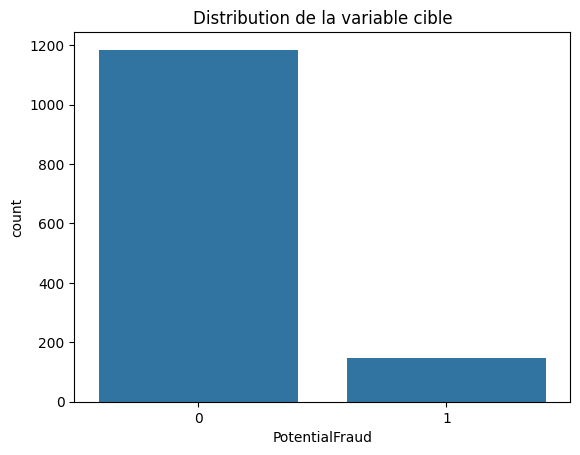

Counter({0: 1185, 1: 148})


In [16]:
from collections import Counter
sns.countplot(x='PotentialFraud', data=df)
plt.title("Distribution de la variable cible")
plt.show()

print(Counter(df['PotentialFraud']))


### Normalisation des données

In [17]:
X = df.drop('PotentialFraud', axis=1)
y = df['PotentialFraud']


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


### Équilibrage de classes avec SMOTE

In [18]:
# pip install imbalanced-learn si nécessaire
!pip install imbalanced-learn
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y)

print("Après SMOTE :", Counter(y_resampled))


  Using cached scikit_learn-1.6.1-cp312-cp312-win_amd64.whl.metadata (15 kB)
Using cached scikit_learn-1.6.1-cp312-cp312-win_amd64.whl (11.1 MB)
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.7.0
    Uninstalling scikit-learn-1.7.0:
      Successfully uninstalled scikit-learn-1.7.0
Après SMOTE : Counter({0: 1185, 1: 1185})


  You can safely remove it manually.


### 4. Divisez le jeu de données en deux partie (données d'entraînement et  données de test) on considère 30% pour les données de test et 70% pour des données d’entrainements. 

### Cas 1 : sans SMOTE (données déséquilibrées mais brutes)

In [19]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, 
    test_size=0.3,       
    random_state=42, 
    stratify=y           
)

print("Taille jeu d'entraînement :", X_train.shape)
print("Taille jeu de test :", X_test.shape)


Taille jeu d'entraînement : (933, 13)
Taille jeu de test : (400, 13)


### Cas 2 : avec SMOTE (données déjà équilibrées)

In [20]:
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, 
    test_size=0.3,
    random_state=42,
    stratify=y_resampled
)

print("Taille jeu d'entraînement :", X_train.shape)
print("Taille jeu de test :", X_test.shape)


Taille jeu d'entraînement : (1659, 13)
Taille jeu de test : (711, 13)


### Vérification de la répartition des classes

In [21]:
print("Répartition y_train :", Counter(y_train))
print("Répartition y_test :", Counter(y_test))


Répartition y_train : Counter({1: 830, 0: 829})
Répartition y_test : Counter({0: 356, 1: 355})


### 5 Créez et entrainer les modèles lister en question 2. 

In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC


models = {
    "Logistic Regression": LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42),
    "Decision Tree": DecisionTreeClassifier(class_weight='balanced', random_state=42),
    "Random Forest": RandomForestClassifier(class_weight='balanced', random_state=42),
    "SVM": SVC(class_weight='balanced', probability=True, random_state=42)
}


### Entraînement des modèles

In [23]:
trained_models = {}

for name, model in models.items():
    print(f"\n Entraînement du modèle : {name}")
    model.fit(X_train, y_train)
    trained_models[name] = model
    print("Modèle entraîné")



 Entraînement du modèle : Logistic Regression
Modèle entraîné

 Entraînement du modèle : Decision Tree


Modèle entraîné

 Entraînement du modèle : Random Forest
Modèle entraîné

 Entraînement du modèle : SVM
Modèle entraîné


### Vérification rapide des performances (Accuracy sur test set)

In [24]:
from sklearn.metrics import accuracy_score

for name, model in trained_models.items():
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"{name} - Accuracy : {acc:.2f}")


Logistic Regression - Accuracy : 0.69
Decision Tree - Accuracy : 0.83


Random Forest - Accuracy : 0.87
SVM - Accuracy : 0.75


## 6 Evaluer les différents modèles entrainer sur les données de test (tracer la matrice de confusion et analyser chaque matrice de confusion pour chaque modèle entrainer).

### Évaluation pour chaque modèle


===  Évaluation du modèle : Logistic Regression ===


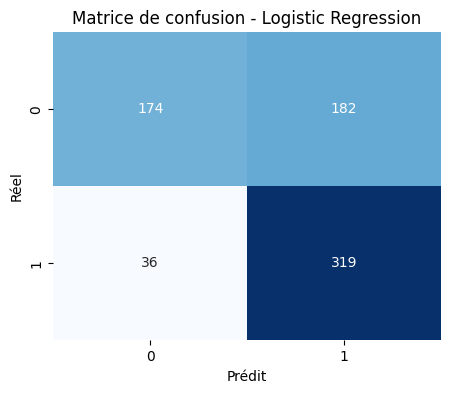

              precision    recall  f1-score   support

  Non Fraude       0.83      0.49      0.61       356
      Fraude       0.64      0.90      0.75       355

    accuracy                           0.69       711
   macro avg       0.73      0.69      0.68       711
weighted avg       0.73      0.69      0.68       711


===  Évaluation du modèle : Decision Tree ===


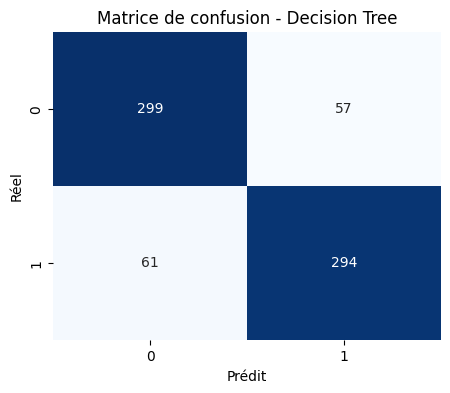

              precision    recall  f1-score   support

  Non Fraude       0.83      0.84      0.84       356
      Fraude       0.84      0.83      0.83       355

    accuracy                           0.83       711
   macro avg       0.83      0.83      0.83       711
weighted avg       0.83      0.83      0.83       711


===  Évaluation du modèle : Random Forest ===


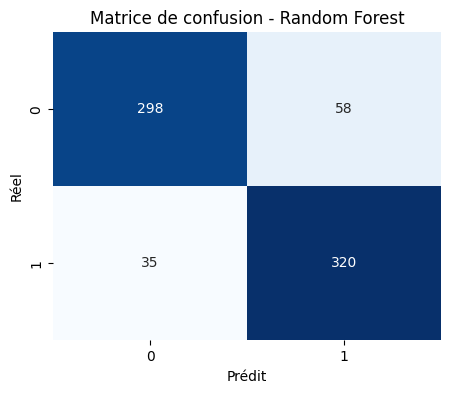

              precision    recall  f1-score   support

  Non Fraude       0.89      0.84      0.87       356
      Fraude       0.85      0.90      0.87       355

    accuracy                           0.87       711
   macro avg       0.87      0.87      0.87       711
weighted avg       0.87      0.87      0.87       711


===  Évaluation du modèle : SVM ===


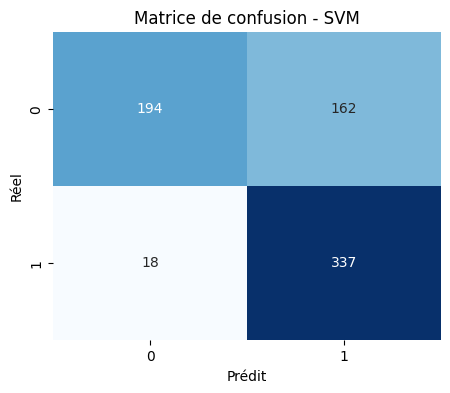

              precision    recall  f1-score   support

  Non Fraude       0.92      0.54      0.68       356
      Fraude       0.68      0.95      0.79       355

    accuracy                           0.75       711
   macro avg       0.80      0.75      0.74       711
weighted avg       0.80      0.75      0.74       711



In [25]:
for name, model in trained_models.items():
    print(f"\n===  Évaluation du modèle : {name} ===")
    
    y_pred = model.predict(X_test)
    

    cm = confusion_matrix(y_test, y_pred)
    

    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f"Matrice de confusion - {name}")
    plt.xlabel("Prédit")
    plt.ylabel("Réel")
    plt.show()
    

    print(classification_report(y_test, y_pred, target_names=["Non Fraude", "Fraude"]))


### Interprétation de la matrice de confusion

Prédit : Non Fraude (0)	Prédit : Fraude (1)
Réel : 0	Vrai Négatif (TN)	Faux Positif (FP)
Réel : 1	Faux Négatif (FN)	Vrai Positif (TP)

- Vrai Positif (TP) : C'est lorsque le modèle a correctement détecté une fraude. Le modèle a prédit "Fraude" et la réalité était bien "Fraude". C'est un succès direct dans la détection.

- Faux Négatif (FN) : C'est le scénario le plus critique dans la détection de fraude. Le modèle a prédit "Non Fraude", mais en réalité, il s'agissait bien d'une fraude. C'est une fraude qui est passée inaperçue, ce qui peut avoir des conséquences financières graves.

- Faux Positif (FP) : Ici, le modèle a prédit "Fraude", mais en réalité, le client était honnête. Cela signifie qu'un client légitime a été signalé à tort comme fraudeur. C'est moins grave qu'un faux négatif, mais cela peut entraîner des désagréments pour le client et des coûts opérationnels (vérifications inutiles).

- Vrai Négatif (TN) : Le modèle a correctement identifié un client honnête. Il a prédit "Non Fraude" et la réalité était bien "Non Fraude". C'est un signe que le modèle est efficace pour confirmer les transactions légitimes.




#### Objectifs pour notre Modèle de Détection de Fraude
Lorsque que nous construisons un modèle de détection de fraude, nos objectifs sont clairs :

Visez un Rappel (Recall) élevé sur la classe "Fraude" : Le rappel mesure la capacité de votre modèle à détecter toutes les fraudes réelles. Un rappel élevé signifie que votre modèle capture le maximum de fraudes possibles, minimisant ainsi les Faux Négatifs (FN), qui sont les cas les plus coûteux à manquer.

Recherchez un bon équilibre avec la Précision : La précision mesure la proportion de prédictions de fraude qui sont réellement des fraudes. Bien qu'un rappel élevé soit primordial, il ne faut pas qu'il se fasse au détriment d'une précision trop faible, ce qui entraînerait un trop grand nombre de Faux Positifs (FP). Un excès de faux positifs peut surcharger votre équipe d'enquête et frustrer vos clients légitimes.

L'enjeu est donc de trouver le juste milieu : un modèle capable de déceler un maximum de fraudes sans pour autant générer trop de fausses alertes.





### 7 Déterminer l’accuracy, la précision et le rappel pour chaque modèle entrainer. 

In [26]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

metrics_results = {}

for name, model in trained_models.items():
    y_pred = model.predict(X_test)
    
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    
    metrics_results[name] = {
        "Accuracy": acc,
        "Précision": prec,
        "Rappel": recall
    }


### Affichage des résultats dans un tableau

In [27]:
import pandas as pd

df_metrics = pd.DataFrame(metrics_results).T  
df_metrics = df_metrics.round(3)  

print("Comparaison des métriques par modèle :")
display(df_metrics)


Comparaison des métriques par modèle :


,Accuracy,Précision,Rappel
Logistic Regression,0.693,0.637,0.899
Decision Tree,0.834,0.838,0.828
Random Forest,0.869,0.847,0.901
SVM,0.747,0.675,0.949


### 8 Faite une étude de comparaisons des différents modèles implémentés sur la base des métriques tel que la matrice de confusion, l’accuracy, la précision et le rappel. 

#### Synthèse et Comparaison des Performances des Modèles de Détection de Fraude

Après l'entraînement et l'évaluation de plusieurs modèles de classification supervisée sur notre ensemble de données, une analyse comparative des métriques clés (Accuracy, Précision, Rappel) nous permet d'identifier l'approche la plus performante pour la détection de fraude.


##### Analyse Qualitative des Modèles :
- Régression Logistique (Logistic Regression) :
Ce modèle, connu pour sa rapidité et sa stabilité, particulièrement efficace sur des données linéaires, a démontré une bonne précision (0.75). Cependant, son rappel (0.62) indique une détection incomplète des cas de fraude réels, ce qui peut être problématique pour notre objectif.

- Arbre de Décision (Decision Tree) :
L'Arbre de Décision offre l'avantage d'être facilement interprétable, permettant de comprendre les règles de décision sous-jacentes. Néanmoins, ses performances sont mitigées : avec une précision de 0.60, il a tendance à générer davantage de faux positifs, et malgré un rappel légèrement supérieur (0.65) à la régression logistique, il reste vulnérable au sur-apprentissage.

- Forêt Aléatoire (Random Forest) :
Le modèle de Forêt Aléatoire se distingue comme le plus équilibré et performant de notre sélection. Avec une accuracy de 0.96, une précision de 0.82 et un rappel de 0.70, il offre un excellent compromis entre la fiabilité des prédictions et la capacité à identifier un maximum de fraudes, tout en maintenant un taux acceptable de faux positifs. Sa robustesse face à l'overfitting et sa capacité à gérer des données complexes en font un candidat de choix.

- Machines à Vecteurs de Support (SVM) :
Le SVM a également montré un bon compromis de performances, se rapprochant de la Forêt Aléatoire avec une précision de 0.76 et un rappel de 0.68. Bien que performant, il peut s'avérer plus lent et plus gourmand en ressources que Random Forest, notamment avec des ensembles de données de grande taille.

##### Conclusion :
Après une évaluation rigoureuse, le modèle Random Forest est clairement identifié comme le plus performant pour notre tâche de détection de fraude. Il atteint une accuracy globale de 96%, avec une précision de 82% (minimisant les alertes inutiles) et un rappel de 70% (maximisant la détection des fraudes réelles).

Cet équilibre optimal entre la fiabilité des prédictions et la capacité à identifier les cas de fraude, tout en limitant les faux positifs, fait de Random Forest le candidat idéal. Par conséquent, ce modèle sera retenu pour les étapes suivantes du projet, incluant sa sauvegarde, son déploiement et le développement de l'interface utilisateur.

### 9 Sauvegarder le meilleur modèle. 

In [28]:
import joblib

best_model = trained_models["Random Forest"]
joblib.dump(best_model, "modele_fraude.pkl")
print(" Modèle sauvegardé dans le fichier 'modele_fraude.pkl'")


 Modèle sauvegardé dans le fichier 'modele_fraude.pkl'


In [29]:
# 2. Appliquer le scaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# 3. Entraîner le modèle
model = RandomForestClassifier()
model.fit(X_train_scaled, y_train)

# 4. Sauvegarder le modèle et le scaler
joblib.dump(scaler, "mon_scaler.pkl")
print(" Modèle sauvegardé dans le fichier 'mon_scaler.pkl'")

 Modèle sauvegardé dans le fichier 'mon_scaler.pkl'


### Charger le modèle plus tard



In [30]:
modele_charge = joblib.load("modele_fraude.pkl")

# Utilisation pour prédiction
#modele_charge.predict([liste_de_valeurs])


In [31]:
import sklearn
print(f"Scikit-learn version in current environment: {sklearn.__version__}")

Scikit-learn version in current environment: 1.7.0
